In [1]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

In [11]:
TRAIN_IMG_FOLDER = '/content/drive/MyDrive/TRAIN/'
TEST_IMG_FOLDER = '/content/drive/MyDrive/Test/'

train_set_files = os.listdir(TRAIN_IMG_FOLDER)
test_set_files = os.listdir(TEST_IMG_FOLDER)

width  = 92
height = 112

In [5]:
pip install opencv-python

In [6]:
import cv2

In [12]:

train_image_names = os.listdir(TRAIN_IMG_FOLDER)
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64) # initialize the tensor

for i in range(len(train_image_names)):
    img = plt.imread(TRAIN_IMG_FOLDER + train_image_names[i])
    training_tensor[i,:] = np.array(img, dtype='float64').flatten() # update tensor value


##Creating Testing data Tensor
test_image_names = os.listdir(TEST_IMG_FOLDER)
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(TEST_IMG_FOLDER + test_image_names[i])
    img=cv2.resize(img,(112,92))
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()


In [13]:
print('training_tensor Shape:', training_tensor.shape)

training_tensor Shape: (240, 10304)


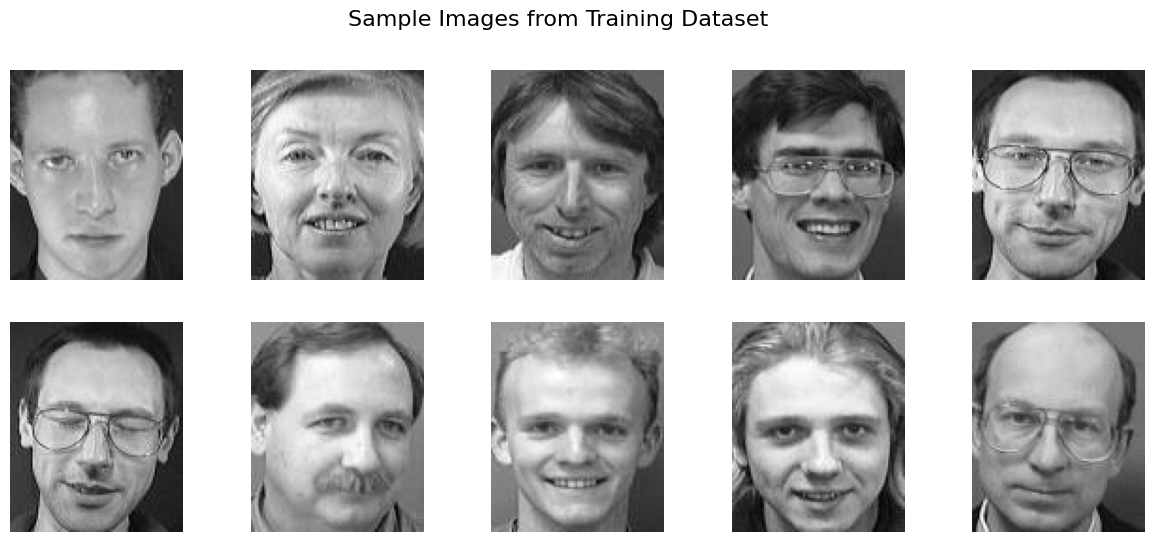

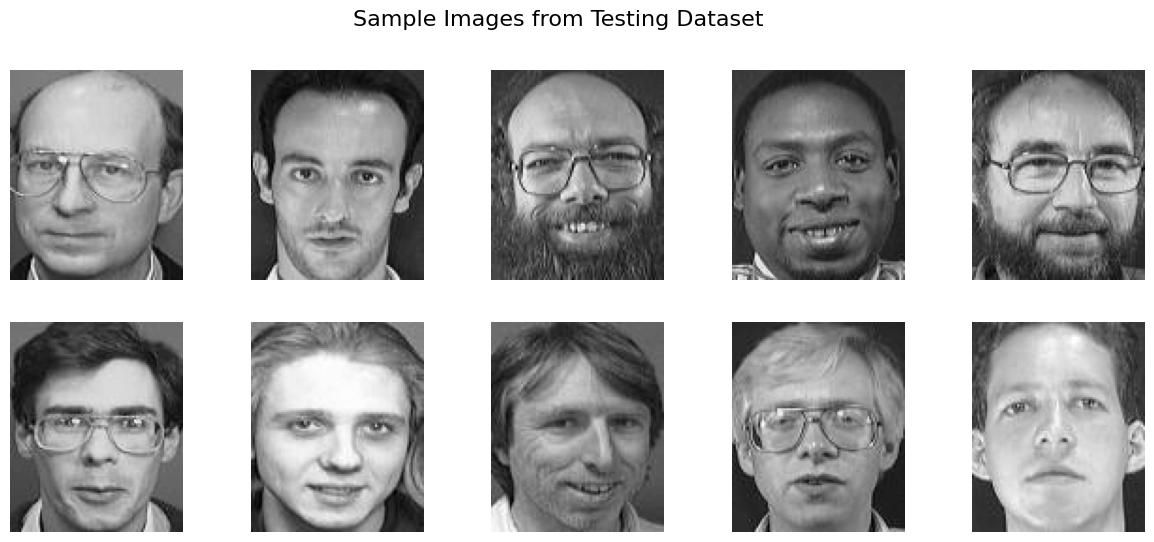

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.suptitle('Sample Images from Training Dataset', fontsize=16)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = plt.imread(TRAIN_IMG_FOLDER + train_image_names[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()

plt.figure(figsize=(15, 6))
plt.suptitle('Sample Images from Testing Dataset', fontsize=16)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = plt.imread(TEST_IMG_FOLDER + test_image_names[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()


In [27]:
training_tensor.size

2472960

In [24]:
mean_face = np.mean(training_tensor, axis=0)
mean_face_image = mean_face.reshape(height, width)

In [28]:
mean_face.size

10304

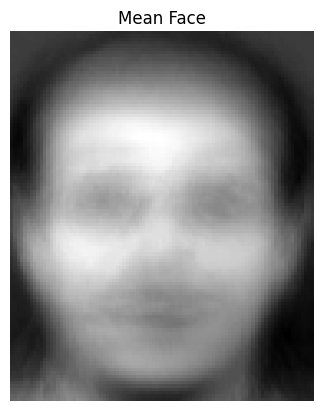

In [26]:
plt.show()
plt.imshow(mean_face_image, cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

plt.show()

In [29]:

centered_training_tensor = np.zeros_like(training_tensor)
for i in range(len(train_image_names)):
    centered_training_tensor[i] = training_tensor[i] - mean_face


In [30]:
centered_training_tensor.size

2472960

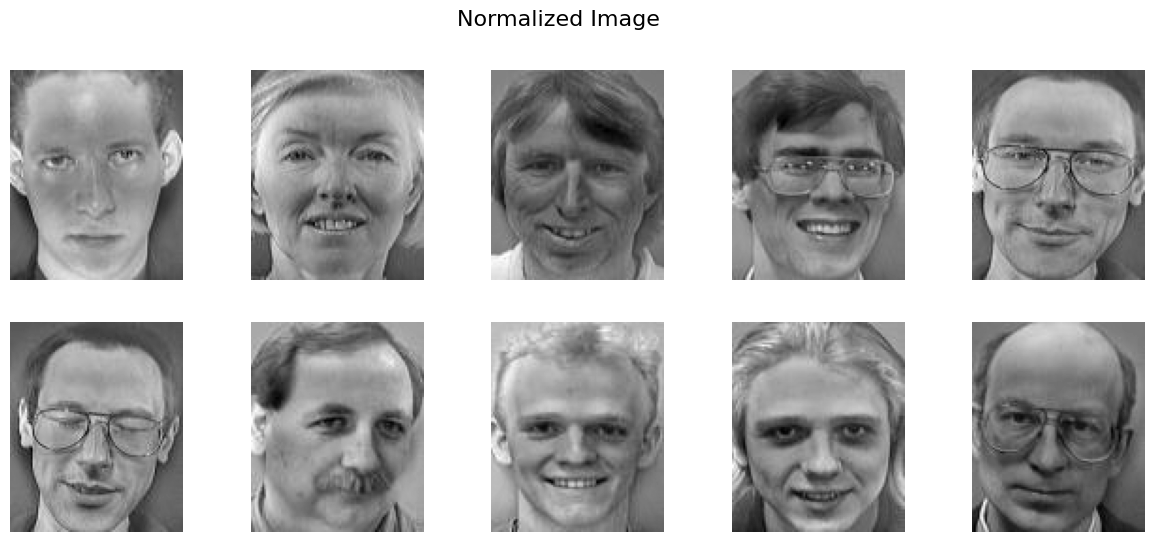

In [31]:
plt.figure(figsize=(15, 6))
plt.suptitle('Normalized Image', fontsize=16)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = centered_training_tensor[i].reshape(height, width)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()

In [32]:
# Find the transpose of centered_training_tensor
centered_training_tensor_transpose = np.transpose(centered_training_tensor)


In [33]:
centered_training_tensor_transpose.shape

(10304, 240)

In [34]:

covariance_matrix = np.cov(centered_training_tensor_transpose)


In [35]:
covariance_matrix.shape

(10304, 10304)

In [37]:
covariance_matrix_1 = np.cov(centered_training_tensor)

In [38]:
covariance_matrix_1.shape

(240, 240)

In [39]:

eigenvalues, eigenvectors, = np.linalg.eig(covariance_matrix_1)
print('eigenvalues.shape: {} eigenvectors.shape: {}'.format(eigenvalues.shape, eigenvectors.shape))

eigenvalues.shape: (240,) eigenvectors.shape: (240, 240)


In [40]:


sorted_ind = sorted(range(eigenvalues.shape[0]), key=lambda k: eigenvalues[k], reverse=True)
eigvalues_sort = eigenvalues[sorted_ind]
eigvectors_sort = eigenvectors[sorted_ind]


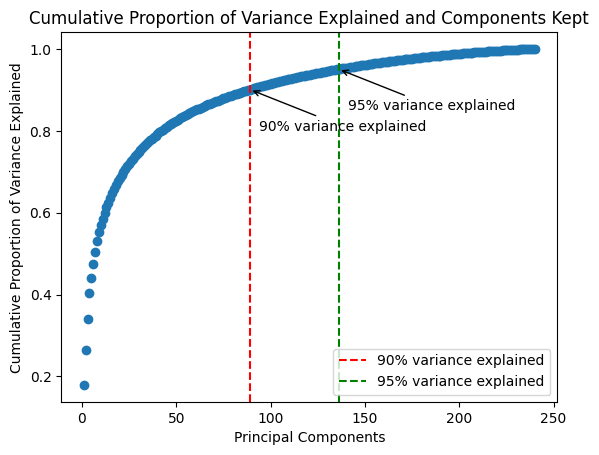

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already computed var_comp_sum and num_comp

# Plot cumulative proportion of variance explained
plt.scatter(num_comp, var_comp_sum)
plt.title('Cumulative Proportion of Variance Explained and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')

# Find the indices where cumulative variance exceeds thresholds
index_90 = np.argmax(var_comp_sum >= .90) + 1
index_95 = np.argmax(var_comp_sum >= .95) + 1

plt.annotate('90% variance explained', xy=(index_90, var_comp_sum[index_90 - 1]), xytext=(index_90 + 5, var_comp_sum[index_90 - 1] - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             )
plt.annotate('95% variance explained', xy=(index_95, var_comp_sum[index_95 - 1]), xytext=(index_95 + 5, var_comp_sum[index_95 - 1] - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             )

plt.axvline(x=index_90, color='r', linestyle='--', label='90% variance explained')
plt.axvline(x=index_95, color='g', linestyle='--', label='95% variance explained')

plt.legend()
plt.show()


In [75]:
reduced_data = np.array(eigvectors_sort[:index_95]).transpose()
print(training_tensor.transpose().shape, reduced_data.shape)

(10304, 240) (240, 136)


In [76]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()
proj_data.shape

(136, 10304)

In [78]:
w = np.array([np.dot(proj_data,i) for i in centered_training_tensor])
print(w.shape)

(240, 136)


In [82]:
def recogniser(test_image_names, train_image_names,proj_data,w, t0=2e8, prn=False):

    count        = 0
    num_images   = 0
    correct_pred = 0

    result = []
    wts = []

    #False match rate (FMR)
    FMR_count = 0

    #False non-match rate (FNMR)
    FNMR_count = 0


    test_image_names2 = sorted(test_image_names)

    for img in test_image_names2:

        unknown_face = plt.imread(TEST_IMG_FOLDER+img)
        num_images += 1

        unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
        normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

        w_unknown = np.dot(proj_data, normalised_uface_vector)
        diff  = w - w_unknown
        norms = np.linalg.norm(diff, axis=1)
        index = np.argmin(norms)

        wts.append([count, norms[index]])

        if prn: print('Input:'+'.'.join(img.split('.')[:2]), end='\t')
        count+=1

        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        if norms[index] < t0: # It's a face
            if match:
                if prn: print('Matched:' + train_image_names[index], end = '\t')
                correct_pred += 1
                result.append(1)
            else:
                if prn: print('F/Matched:'+train_image_names[index], end = '\t')
                result.append(0)
                FMR_count += 1
        else:
            if match:
                if prn: print('Unknown face!'+train_image_names[index], end = '\t')
                FNMR_count +=1

            else:
                pass
                correct_pred += 1



        if prn: print(norms[index], end=' ')
        if prn: print()



    FMR = FMR_count/num_images
    FNMR = FNMR_count/num_images


    print('Correct predictions: {}/{} = {} \t\t'.format(correct_pred, num_images, correct_pred/num_images), end=' ')
    print('FMR: {} \t'.format(FMR), end=' ')
    print('FNMR: {} \t'.format(FNMR))



    return wts, result, correct_pred, num_images, FMR, FNMR


wts, result, correct_pred, num_images, FMR, FNMR =recogniser(test_image_names, train_image_names,proj_data,w, t0=2e8, prn=True)

Input:s10_10.pgm	F/Matched:s8_1.pgm	43695962.36021118 
Input:s10_7.pgm	Matched:s10_4.pgm	23061222.164467767 
Input:s10_8.pgm	F/Matched:s38_5.pgm	37508433.63301559 
Input:s10_9.pgm	F/Matched:s38_2.pgm	29018884.056576304 
Input:s11_10.pgm	Matched:s11_6.pgm	33201345.897643328 
Input:s11_7.pgm	Matched:s11_1.pgm	15324990.225468187 
Input:s11_8.pgm	Matched:s11_3.pgm	35010167.71874177 
Input:s11_9.pgm	Matched:s11_3.pgm	16935833.997399714 
Input:s12_10.pgm	F/Matched:s40_2.pgm	26714515.659686077 
Input:s12_7.pgm	Matched:s12_4.pgm	12138543.11549382 
Input:s12_8.pgm	Matched:s12_1.pgm	15903960.358657088 
Input:s12_9.pgm	F/Matched:s25_3.pgm	24694603.506125063 
Input:s13_10.pgm	Matched:s13_5.pgm	11267091.218999576 
Input:s13_7.pgm	Matched:s13_6.pgm	17163814.192933504 
Input:s13_8.pgm	Matched:s13_6.pgm	18104340.92569631 
Input:s13_9.pgm	Matched:s13_5.pgm	13295986.422194974 
Input:s14_10.pgm	F/Matched:s37_5.pgm	37321148.56254525 
Input:s14_7.pgm	F/Matched:s37_2.pgm	24705299.27982171 
Input:s14_8.pgm	M